In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
def perspectiveTransform(img, pts_input, pts_output):
    raws, cols, ch = img.shape
    M = cv2.getPerspectiveTransform(pts_input, pts_output)
    outputImg = cv2.warpPerspective(img, M, (800, 800))
    return outputImg

In [50]:
def reduceNoise(img, medianBoxSize, kernelSize):
    cv2.medianBlur(img, medianBoxSize)
    kernel = np.ones((kernelSize, kernelSize), np.uint8)
    outputImg = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return outputImg

In [51]:
def retCrossPoints(img):
    crossPoints = []
    interval = img.shape[0]/18
    for i in range(19):
        row = []
        for j in range(19):
            x = int(i*interval)
            y = int(j*interval)
            if i==0:
                x += 7
            if j==0:
                y += 7
            if i==18:
                x -= 7
            if j==18:
                y -= 7
            row.append([y, x])    
        crossPoints.append(row)
    return crossPoints

In [52]:
def drawCrossPoints(img):
    outputImg = img.copy()
    crossPoints = retCrossPoints(img)    
    for p_row in crossPoints:
        for p in p_row:
            cv2.circle(outputImg, (p[0],p[1]), 2, (0, 0, 255), 3)
            
    return outputImg

In [53]:
def checkStonePosition(img):
    crossPoints = retCrossPoints(img)
    conditionOfBoard = []
    none = 10.0
    blackStone = 80.0
    whiteStone = 120.0
    
    for p_row in crossPoints:
        condition_row = []
        for p in p_row:
            
            rect = img[p[1]-3:p[1]+7, p[0]-3:p[0]+7]
            colorAve = np.average(rect)
            #print('aveColor around' + str([p[1],p[0]]) + ':' +str(colorAve))
                      
            if colorAve < none:
                condition_row.append(-1)
            elif colorAve < blackStone:
                condition_row.append(0)
            elif colorAve > whiteStone:
                condition_row.append(255)
                
        conditionOfBoard.append(condition_row)
    return conditionOfBoard

In [54]:
def addStateToNeighbourhood(state, neighbourhood):
    isAdded = False
    if state<11 and state>=0:
        neighbourhood.append(0)
        isAdded = True
    elif state>244:
        neighbourhood.append(255)
        isAdded = True
    return [neighbourhood, isAdded]

In [55]:
def checkTeritory(point,territoryTable):
    x, y = point[:]
    neighbourhood = []
    
    # 周りの確定済みの状態を近傍リストに追加
    # 左上
    if x>0 and y>0:
        leftUpperState = territoryTable[x-1][y-1]
        neighbourhood = addStateToNeighbourhood(leftUpperState, neighbourhood)[0]
    # 上
    if x>0:
        upperState = territoryTable[x-1][y]
        neighbourhood = addStateToNeighbourhood(upperState,neighbourhood)[0]
    # 右上
    if x>0 and y+1<19:
        rightUpperState = territoryTable[x-1][y+1]
        neighbourhood = addStateToNeighbourhood(rightUpperState,neighbourhood)[0]
    # 左
    if y>0:
        leftState = territoryTable[x][y-1]
        neighbourhood = addStateToNeighbourhood(leftState,neighbourhood)[0]

    # 残りの状態を石に当たるまで走査
    # 右
    j = 1
    while y+j<19:
        rightState = territoryTable[x][y+j]
        neighbourhood,flag = addStateToNeighbourhood(rightState,neighbourhood)[:]
        if flag:
            break
        else:
            j += 1
    # 左下
    i = 1
    j = 1
    while x+i<19 and y-j>=0:
        leftButtomState = territoryTable[x+i][y-j]
        neighbourhood,flag = addStateToNeighbourhood(leftButtomState,neighbourhood)[:]
        if flag:
            break
        else:
            i += 1
            j += 1
    # 下
    i = 1
    while x+i<19:
        buttomState = territoryTable[x+i][y]
        neighbourhood,flag = addStateToNeighbourhood(buttomState,neighbourhood)[:]
        if flag:
            break
        else:
            i += 1
    # 右下
    i = 1
    j = 1
    while x+i<19 and y+j<19:
        rightButtomState = territoryTable[x+i][y+j]
        neighbourhood,flag = addStateToNeighbourhood(rightButtomState,neighbourhood)[:]
        if flag:
            break
        else:
            i += 1
            j += 1
    
    # 近傍のリストのどちらが多いか
    if neighbourhood.count(0) > neighbourhood.count(255):
        targetState = 10
    else:
        targetState = 245

    territoryTable[x][y] = targetState
    return territoryTable

In [56]:
def makeTerritoryTable(stonePosition):
    territoryTable = stonePosition.copy()
    for x in range(19):
        for y in range(19):
            if territoryTable[x][y]==-1:
                point = [x,y]
                territoryTable = checkTeritory(point,territoryTable)            
    return territoryTable

In [57]:
def drawTerritoryColor(img,territoryTable):
    outputImg = img.copy()
    crossPoints = retCrossPoints(img)
    i = 0
    for p_row in crossPoints:
        j = 0
        for p in p_row:
            state = territoryTable[i][j]
            if state==10:
                cv2.circle(outputImg, (p[0],p[1]), 2, (0, 0, 0), 3)
            elif state==245:
                cv2.circle(outputImg, (p[0],p[1]), 2, (255, 255, 255), 3)
            j += 1
        i += 1
    return outputImg

In [58]:
def calculateTerritory(territoryTable):
    black = 0
    white = 0
    for row in territoryTable:
        black += row.count(10)
        white += row.count(245)
    return [black, white]

In [59]:
# == start ==

In [60]:
#filename = 'sample/IMG_5618'
#filename = 'sample/IMG_7221'
filename = 'sample/IMG_5604'
originalImg = cv2.imread(filename+'.JPG')

In [61]:
 #cornerOfGoBoard = np.float32([[594,462], [2471,250], [2704,2183], [529,2235]])
#cornerOfGoBoard = np.float32([[528,114], [1400,171], [1440,1090], [502,1119]])
cornerOfGoBoard = np.float32([[801,503],[2617,156],[2810,2212],[789,2152]])
cornerOfImage = np.float32([[0,0], [800,0], [800,800], [0, 800]])

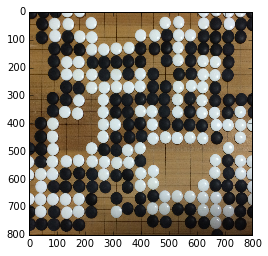

In [62]:
boardImg = perspectiveTransform(originalImg, cornerOfGoBoard, cornerOfImage)
plt.imshow(cv2.cvtColor(boardImg, cv2.COLOR_BGR2RGB))
plt.show()
#cv2.imwrite('boardImg.png', boardImg)

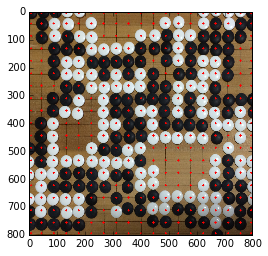

In [63]:
boardWithPointsImg = drawCrossPoints(boardImg)
plt.imshow(cv2.cvtColor(boardWithPointsImg, cv2.COLOR_BGR2RGB))
plt.show()
#cv2.imwrite('boardWithPointsImg.png', boardWithPointsImg)

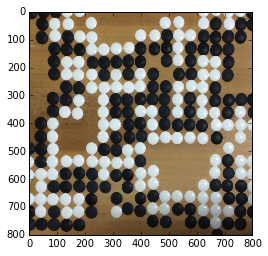

In [64]:
noiseReducedImg = reduceNoise(boardImg, 7, 5)
plt.imshow(cv2.cvtColor(noiseReducedImg, cv2.COLOR_BGR2RGB))
plt.show()
#cv2.imwrite('noiseReducedImg.png', noiseReducedImg)

In [65]:
hsvImg = cv2.cvtColor(noiseReducedImg, cv2.COLOR_BGR2HSV)

In [66]:
beige = np.uint8([[[70, 115, 140]]])
hsv_beige = cv2.cvtColor(beige,cv2.COLOR_BGR2HSV)
print(hsv_beige)
lower_beige = np.array([10,50,50])
upper_beige = np.array([30,255,255])

[[[ 19 128 140]]]


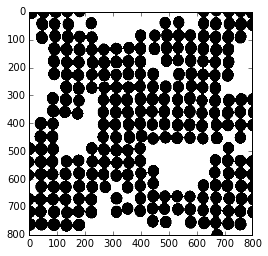

In [67]:
mask_beige = cv2.inRange(hsvImg, lower_beige, upper_beige)
plt.imshow(cv2.cvtColor(mask_beige, cv2.COLOR_GRAY2RGB))
plt.show()
#cv2.imwrite('mask_beige.png', mask_beige)

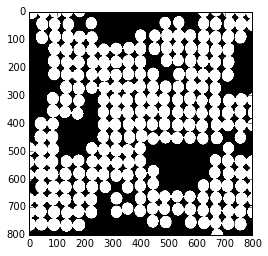

In [68]:
mask_negaposi = cv2.bitwise_not(mask_beige)
plt.imshow(cv2.cvtColor(mask_negaposi, cv2.COLOR_GRAY2RGB))
plt.show()
#cv2.imwrite('mask_negaposi.png', mask_negaposi)

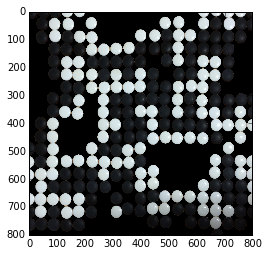

In [69]:
res = cv2.bitwise_and(boardImg,boardImg, mask= mask_negaposi)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()
#cv2.imwrite('res.png', res)

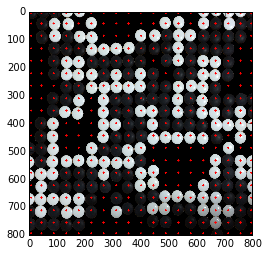

In [70]:
resWithPointsImg = drawCrossPoints(res)
plt.imshow(cv2.cvtColor(resWithPointsImg, cv2.COLOR_BGR2RGB))
plt.show()
#cv2.imwrite('resWithPointsImg.png', resWithPointsImg)

In [71]:
stonePosition = checkStonePosition(res)
print(stonePosition)

[[0, 0, 0, 255, 255, -1, -1, -1, -1, -1, -1, -1, -1, -1, 255, 255, 255, 255, 0], [-1, 0, 255, 255, -1, 255, -1, -1, -1, -1, -1, 255, 255, -1, 255, 0, 255, 0, 0], [-1, 0, 255, 0, 255, 255, -1, -1, -1, 255, 255, 0, 255, 255, 0, 0, 0, 0, -1], [-1, -1, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, -1, -1], [-1, -1, 0, 255, 255, 0, 0, 0, 0, 0, -1, 0, 255, 0, 255, 255, 0, -1, -1], [-1, -1, 0, 255, 255, 255, 0, 255, 0, 255, 0, -1, 0, 0, 255, 255, 0, -1, -1], [-1, -1, -1, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, -1, -1, -1], [-1, -1, 0, 0, 255, -1, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0], [-1, -1, 0, 255, 255, -1, 255, 0, 0, 255, 255, 0, 255, 0, 255, 255, 0, 255, 0], [-1, 0, 255, -1, -1, -1, 255, 255, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255], [-1, 0, 255, -1, -1, -1, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, -1, 255, -1], [0, 0, 255, -1, -1, 255, 0, 0, 255, 255, -1, -1, -1, -1, -1, -1, 255, -1, -1], [255, 0, 255, 255, 255, 255, 255, 255, 255, 0, -1, -1, -1, -1, -1

In [72]:
territoryTable = makeTerritoryTable(stonePosition)
print(territoryTable)

[[0, 0, 0, 255, 255, 245, 245, 245, 245, 245, 245, 245, 245, 245, 255, 255, 255, 255, 0], [10, 0, 255, 255, 245, 255, 245, 245, 245, 245, 245, 255, 255, 245, 255, 0, 255, 0, 0], [10, 0, 255, 0, 255, 255, 245, 245, 245, 255, 255, 0, 255, 255, 0, 0, 0, 0, 10], [10, 10, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 255, 0, 0, 0, 0, 10, 10], [10, 10, 0, 255, 255, 0, 0, 0, 0, 0, 10, 0, 255, 0, 255, 255, 0, 10, 10], [10, 10, 0, 255, 255, 255, 0, 255, 0, 255, 0, 10, 0, 0, 255, 255, 0, 10, 10], [10, 10, 10, 0, 0, 255, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 10, 10, 10], [10, 10, 0, 0, 255, 245, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0], [10, 10, 0, 255, 255, 245, 255, 0, 0, 255, 255, 0, 255, 0, 255, 255, 0, 255, 0], [10, 0, 255, 245, 245, 245, 255, 255, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255], [10, 0, 255, 245, 245, 245, 255, 0, 0, 0, 255, 255, 255, 255, 255, 0, 245, 255, 245], [0, 0, 255, 245, 245, 255, 0, 0, 255, 255, 245, 245, 245, 245, 245, 245, 255, 245, 245], [255, 0, 255, 255, 255, 25

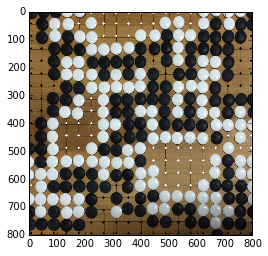

In [73]:
resultImg = drawTerritoryColor(boardImg,territoryTable)
plt.imshow(cv2.cvtColor(resultImg, cv2.COLOR_BGR2RGB))
plt.show()
#cv2.imwrite('resultImg.png', resultImg)

In [74]:
point = calculateTerritory(territoryTable)
print('black:' + str(point[0]))
print('white:' + str(point[1]))

black:58
white:52
